In [1]:
pip install imgaug

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential,  Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
train_path = 'train'
valid_path = 'valid'

In [4]:
print(os.listdir('C:'))

['.DS_Store', '.ipynb_checkpoints', 'axial_train.npy', 'axial_valid.npy', 'coronal.npy', 'coronal_train.npy', 'coronal_valid.npy', 'sagittal_train.npy', 'sagittal_valid.npy', 'train', 'train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'Untitled.ipynb', 'valid', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']


In [5]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [6]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

In [7]:
# training data
train_coronal_data, train_coronal_dir, train_acl_label = get_data('train', 'coronal', 'acl')
train_axial_data, train_axial_dir, train_acl_label = get_data('train', 'axial', 'acl')
train_sagittal_data, train_sagittal_dir, train_acl_label = get_data('train', 'sagittal', 'acl')

In [8]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_acl_label = get_data('valid','coronal','acl')
valid_axial_data, valid_axial_dir, valid_acl_label = get_data('valid','axial','acl')
valid_sagittal_data, valid_sagittal_dir, valid_acl_label = get_data('valid','sagittal','acl')

In [9]:
train_coronal_data.pop(0)

'.DS_Store'

In [10]:
train_axial_data.pop(0)

'.DS_Store'

In [11]:
train_sagittal_data.pop(0)

'.DS_Store'

In [12]:
train_coronal_data

['0000.npy',
 '0001.npy',
 '0002.npy',
 '0003.npy',
 '0004.npy',
 '0005.npy',
 '0006.npy',
 '0007.npy',
 '0008.npy',
 '0009.npy',
 '0010.npy',
 '0011.npy',
 '0012.npy',
 '0013.npy',
 '0014.npy',
 '0015.npy',
 '0016.npy',
 '0017.npy',
 '0018.npy',
 '0019.npy',
 '0020.npy',
 '0021.npy',
 '0022.npy',
 '0023.npy',
 '0024.npy',
 '0025.npy',
 '0026.npy',
 '0027.npy',
 '0028.npy',
 '0029.npy',
 '0030.npy',
 '0031.npy',
 '0032.npy',
 '0033.npy',
 '0034.npy',
 '0035.npy',
 '0036.npy',
 '0037.npy',
 '0038.npy',
 '0039.npy',
 '0040.npy',
 '0041.npy',
 '0042.npy',
 '0043.npy',
 '0044.npy',
 '0045.npy',
 '0046.npy',
 '0047.npy',
 '0048.npy',
 '0049.npy',
 '0050.npy',
 '0051.npy',
 '0052.npy',
 '0053.npy',
 '0054.npy',
 '0055.npy',
 '0056.npy',
 '0057.npy',
 '0058.npy',
 '0059.npy',
 '0060.npy',
 '0061.npy',
 '0062.npy',
 '0063.npy',
 '0064.npy',
 '0065.npy',
 '0066.npy',
 '0067.npy',
 '0068.npy',
 '0069.npy',
 '0070.npy',
 '0071.npy',
 '0072.npy',
 '0073.npy',
 '0074.npy',
 '0075.npy',
 '0076.npy',

In [13]:
def image_extraction(data, path, new_path): 
    '''this function extracts middle slide of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,1)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,1) for train
    np.save(new_path, np.array(new_data))

In [14]:
# image extraction for 3 planes
new_path = 'coronal_train'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [15]:
new_path = 'axial_train'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [16]:
new_path = 'sagittal_train'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [17]:
image = np.load('sagittal_train.npy')

In [18]:
image[0].shape

(256, 256, 1)

In [19]:
# image extraction for 3 planes
new_path = 'coronal_valid'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [20]:
new_path = 'axial_valid'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [21]:
new_path = 'sagittal_valid'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [22]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted dataset'''
    # for eg, (train, sagittal, mensicus)

    plane_dir = f'{plane}.npy'
    data = np.load(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [23]:
# acl
# generate training input
coronal_acl, coronal_acl_label = data_gen('train', 'coronal_train', 'acl')
axial_acl, axial_acl_label = data_gen('train', 'axial_train', 'acl')
sagittal_acl, sagittal_acl_label = data_gen('train', 'sagittal_train', 'acl')

# generate validation
coronal_acl_val, coronal_acl_label_val  = data_gen('valid', 'coronal_valid', 'acl')
axial_acl_val, axial_acl_label_val  = data_gen('valid', 'axial_valid', 'acl')
sagittal_acl_val, sagittal_acl_label_val  = data_gen('valid', 'sagittal_valid', 'acl')

In [24]:
def build_model():
    '''this function creates and builds the cnn model'''
    model = Sequential()
    
    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(1e-3),
                     input_shape=(256,256,1)))
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     activation='relu',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'
                    ,kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    
    return model

In [25]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 6)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2416      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                        

In [26]:
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function fits the data and saves the model and weights'''
    path_dir = '/content/drive/MyDrive' 
    path = f'{path_dir}/{model_name}/own_weights.h5'
    checkpoint_path = f'{path_dir}/{model_name}/own_model.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)],
            verbose=1)

    model.save_weights(path)
    
    return model, history

In [27]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    prec = model.history['precision']
    val_prec = model.history['val_precision']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')
    
    axes[2].plot(prec, label='Training precision', color='blue')
    axes[2].plot(val_prec, label='Testing precision', color='red')
    
    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Binary Crossentropy')

    axes[2].title.set_text('Training and Testing Precision by Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Binary Crossentropy')
    
    plt.xticks(epoch_labels, epoch_labels);    
    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);
    axes[2].legend(fontsize=18);

In [28]:
def build_acl_model():
    '''this function creates and builds the cnn model for the acl'''
    model = Sequential()
    
    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                    #  kernel_regularizer=l2(1e-3),
                     input_shape=(256,256,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     activation='relu',))
                    #  kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'
                    ,kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.7))
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    
    return model

Epoch 1/10
36/36 [==============================] - 69s 2s/step - loss: 1.7045 - accuracy: 0.5796 - precision: 0.1874 - val_loss: 1.4299 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 2/10
36/36 [==============================] - 64s 2s/step - loss: 1.0002 - accuracy: 0.6434 - precision: 0.1905 - val_loss: 0.9984 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 3/10
36/36 [==============================] - 65s 2s/step - loss: 1.0023 - accuracy: 0.6221 - precision: 0.1631 - val_loss: 0.8239 - val_accuracy: 0.5833 - val_precision: 0.7000
Epoch 4/10
36/36 [==============================] - 64s 2s/step - loss: 0.8677 - accuracy: 0.6469 - precision: 0.1929 - val_loss: 0.8233 - val_accuracy: 0.5667 - val_precision: 0.6000
Epoch 5/10
36/36 [==============================] - 65s 2s/step - loss: 0.8586 - accuracy: 0.6761 - precision: 0.1985 - val_loss: 0.8045 - val_accuracy: 0.5417 - val_precision: 0.4615
Epoch 6/10
36/36 [==============================] - 64s 2s/step - loss: 

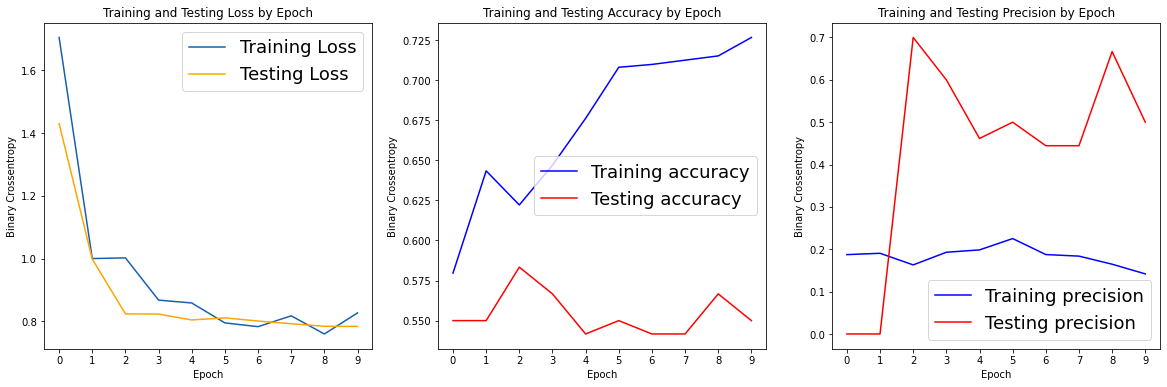

In [29]:
# coronal plane
num_epochs=10

acl_model = build_acl_model()
cor_acl_model, hst_cacl = model_train(acl_model, 'hst_cacl', num_epochs, coronal_acl, coronal_acl_label, coronal_acl_val, coronal_acl_label_val)

# get/plot accuracy
hst_cacl_acc=[]
hst_cacl_acc.append(np.mean(hst_cacl.history['val_accuracy']))
hst_cacl_prec=[]
hst_cacl_prec.append(np.mean(hst_cacl.history['val_precision']))
plot_results(hst_cacl)

Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 1.5837 - accuracy: 0.5788 - precision: 0.1898 - val_loss: 0.8700 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 2/10
36/36 [==============================] - 63s 2s/step - loss: 0.9405 - accuracy: 0.6487 - precision: 0.2019 - val_loss: 0.7915 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 3/10
36/36 [==============================] - 64s 2s/step - loss: 0.8740 - accuracy: 0.6593 - precision: 0.1828 - val_loss: 0.7783 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 4/10
36/36 [==============================] - 56s 2s/step - loss: 0.8418 - accuracy: 0.6690 - precision: 0.1626 - val_loss: 0.7732 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 5/10
36/36 [==============================] - 64s 2s/step - loss: 0.8236 - accuracy: 0.6912 - precision: 0.2169 - val_loss: 0.7602 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 6/10
36/36 [==============================] - 63s 2s/step 

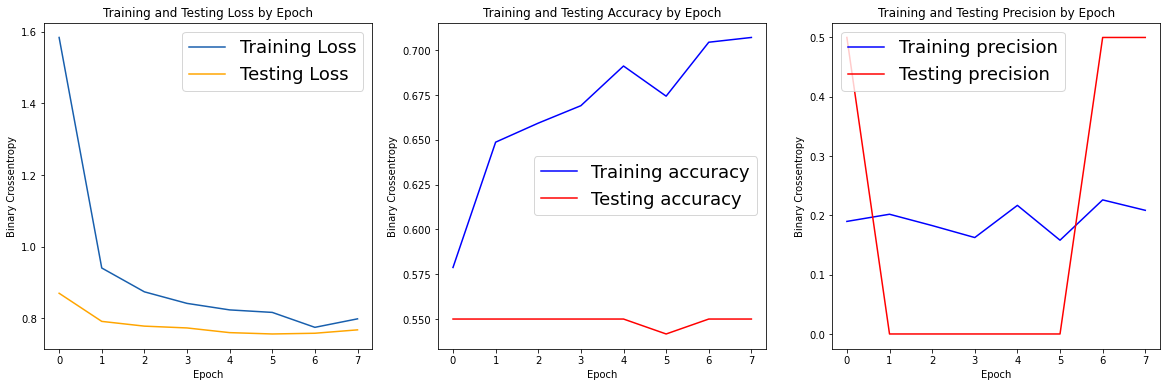

In [30]:
# axial plane
num_epochs=10

acl_model = build_acl_model()
axl_acl_model, hst_aacl = model_train(acl_model, 'hst_aacl', num_epochs, axial_acl, axial_acl_label, axial_acl_val, axial_acl_label_val)

# get/plot accuracy
hst_aacl_acc=[]
hst_aacl_acc.append(np.mean(hst_aacl.history['val_accuracy']))
hst_aacl_prec=[]
hst_aacl_prec.append(np.mean(hst_aacl.history['val_precision']))
plot_results(hst_aacl)

Epoch 1/10
36/36 [==============================] - 68s 2s/step - loss: 1.2360 - accuracy: 0.5743 - precision: 0.1742 - val_loss: 0.8210 - val_accuracy: 0.5333 - val_precision: 0.4167
Epoch 2/10
36/36 [==============================] - 64s 2s/step - loss: 0.9394 - accuracy: 0.6150 - precision: 0.1838 - val_loss: 0.7960 - val_accuracy: 0.5833 - val_precision: 0.6667
Epoch 3/10
36/36 [==============================] - 64s 2s/step - loss: 0.8767 - accuracy: 0.6195 - precision: 0.1934 - val_loss: 0.7871 - val_accuracy: 0.5750 - val_precision: 0.8000
Epoch 4/10
36/36 [==============================] - 56s 2s/step - loss: 0.8275 - accuracy: 0.6425 - precision: 0.1839 - val_loss: 0.7876 - val_accuracy: 0.5833 - val_precision: 0.7500
Epoch 5/10
36/36 [==============================] - 64s 2s/step - loss: 0.8096 - accuracy: 0.6743 - precision: 0.2279 - val_loss: 0.7884 - val_accuracy: 0.5750 - val_precision: 0.8000


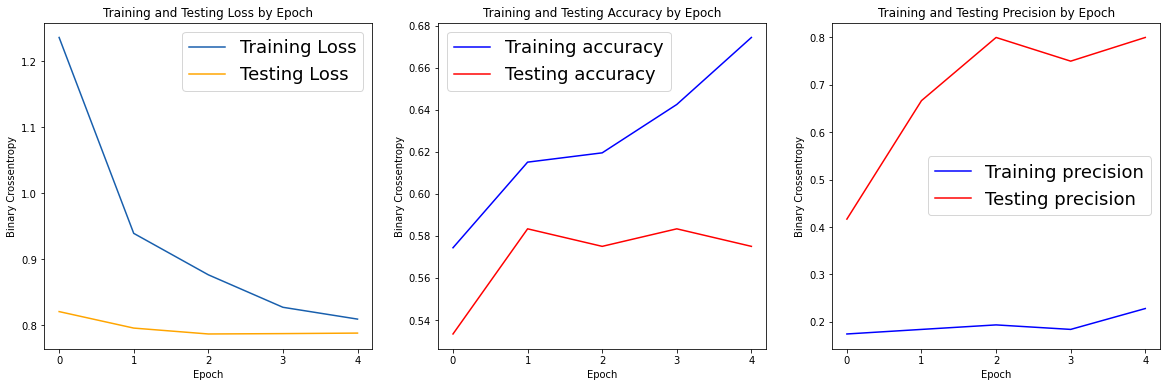

In [31]:
# sagittal plane
num_epochs=10

acl_model = build_acl_model()
sag_acl_model, hst_sacl = model_train(acl_model, 'hst_sacl', num_epochs, sagittal_acl, sagittal_acl_label, sagittal_acl_val, sagittal_acl_label_val)

# get/plot accuracy
hst_sacl_acc=[]
hst_sacl_acc.append(np.mean(hst_sacl.history['val_accuracy']))
hst_sacl_prec=[]
hst_sacl_prec.append(np.mean(hst_sacl.history['val_precision']))
plot_results(hst_sacl)

In [32]:
cmen_scores = cor_acl_model.evaluate(coronal_acl_val, np.array(coronal_acl_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.7839364409446716
Test accuracy: 0.550000011920929


In [33]:
amen_scores = axl_acl_model.evaluate(axial_acl_val, np.array(axial_acl_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.7678982019424438
Test accuracy: 0.550000011920929


In [34]:
smen_scores = sag_acl_model.evaluate(sagittal_acl_val, np.array(sagittal_acl_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.7884054780006409
Test accuracy: 0.574999988079071
